In this notebook, I begin by implementing a custom simulation inspired by my previous work in Colab. This simulation will serve as a foundational example for understanding stochastic processes. I then proceed to utilize the Squidpy package to simulate spatial transcriptomics data. Finally, I demonstrate how to create and store the resulting data in an AnnData format, a key data structure for handling single-cell genomics data in Python.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
#from shapely.geometry import Point
import pymc as pm
import pandas as pd

# Initialize the random number generator
RANDOM_SEED = 8925347
rng = np.random.default_rng(RANDOM_SEED)

In [2]:
# 5 gens from diffrent distribution, 1 gene from similar distributions
clust_gene_mus = np.concatenate((rng.integers(12,55,(4,5)),rng.integers(23,25,(4,1))),axis =1)
clust_gene_mus

array([[31, 22, 29, 26, 23, 23],
       [24, 17, 52, 25, 45, 23],
       [15, 21, 32, 28, 29, 24],
       [28, 24, 54, 19, 27, 24]])

In [3]:
clust_gene_sigmas = pm.draw(pm.Uniform.dist(lower=3, upper=10),draws=20, random_seed=RANDOM_SEED).reshape(4,5)
clust_gene_sigmas = np.concatenate((clust_gene_sigmas,np.repeat(0.5,4).reshape(4,1)),axis =1)
clust_gene_sigmas

array([[4.58483659, 6.0198114 , 6.69244485, 9.55787352, 7.25790271,
        0.5       ],
       [6.21607188, 5.04187114, 9.97955213, 9.98813652, 7.22058204,
        0.5       ],
       [8.84402576, 4.16907916, 5.73760602, 3.19536571, 3.39762495,
        0.5       ],
       [5.41679447, 6.96587996, 3.09625146, 5.62762622, 7.33427476,
        0.5       ]])

In [ ]:
clust_gene_mus = np.concatenate((rng.integers(12,55,(4,2)),rng.integers(23,25,(4,1))),axis =1)
clust_gene_mus

In [ ]:
clust_gene_sigmas = pm.draw(pm.Uniform.dist(lower=3, upper=10),draws=8, random_seed=RANDOM_SEED).reshape(4,2)
clust_gene_sigmas = np.concatenate((clust_gene_sigmas,np.repeat(0.5,4).reshape(4,1)),axis =1)

In [4]:
# Parameters for clusters
num_clusters = 4
min_obs = 3
max_obs = 4

# Parameters for multivariate normal distribution
a0 = 3.5
b1 = 1.5
b2 = 2.5
b3 = 2.5
sigma_a0 = 1.0
sigma_b1 = 0.7
sigma_b2 = 0.3
sigma_b3 = 1.2
rhow_0_1 = -0.8
rhow_0_2 = 0.6
rhow_1_3 = 0.1
rhow_2_3 = 0.9

def makemvn(mean0, mean1, sigma0, sigma1, rho, size):
  mu = [mean0, mean1]
  Rho = np.array([[1, rho], [rho, 1]])
  sigmas = [sigma0, sigma1]
  Sigma = np.diag(sigmas) @ Rho @ np.diag(sigmas)
  return rng.multivariate_normal(mean=mu, cov=Sigma, size=size)

# simulate spots/genes matrix
def spot_gene_sim(num_points,clust_gene_mus,clust_gene_sigmas,prev_arr,ind):
  if prev_arr is None:
    arr = pm.draw(pm.NegativeBinomial.dist(mu=clust_gene_mus[ind,:], alpha=clust_gene_sigmas[ind,:]),draws=num_points, random_seed=RANDOM_SEED)
  else:
    temp_arr = pm.draw(pm.NegativeBinomial.dist(mu=clust_gene_mus[ind,:], alpha=clust_gene_sigmas[ind,:]),draws=num_points, random_seed=RANDOM_SEED)
    arr = np.concatenate((prev_arr,temp_arr),axis =0)
  return arr

# Create random coordinates for clusters
clusters = []
labels = np.arange(num_clusters).tolist()
rng.shuffle(labels)
label = []
prev_arr = None

# Generate points for each cluster with associations
cluster_points = []
for i in range(num_clusters):
    num_points = rng.integers(min_obs, max_obs + 1)
    cluster_center = (rng.uniform(0, 100), rng.uniform(0, 100))
    points = np.round(rng.normal(loc=cluster_center, scale=5, size=(num_points, 2))).astype(int)
    cluster_points.append(points)
    clusters.append(points)
    label.extend([labels[i]] * num_points)
    arr = spot_gene_sim(num_points,clust_gene_mus,clust_gene_sigmas,prev_arr = prev_arr,ind=i)
    prev_arr = arr

# Flatten the list of clusters to get all points
all_points = np.vstack(clusters)

# Generate values with associations between clusters
values = np.zeros(all_points.shape[0])

# Generate associated values for each cluster
num_points_cluster_0 = len(clusters[0])
num_points_cluster_1 = len(clusters[1])
num_points_cluster_2 = len(clusters[2])
num_points_cluster_3 = len(clusters[3])

# Cluster 0 and 1 association
cluster_0_1_values = makemvn(a0, b1, sigma_a0, sigma_b1, rhow_0_1, num_points_cluster_0 + num_points_cluster_1)
values[:num_points_cluster_0] = cluster_0_1_values[:num_points_cluster_0, 0]
values[num_points_cluster_0:num_points_cluster_0 + num_points_cluster_1] = cluster_0_1_values[num_points_cluster_0:, 1]

# Cluster 0 and 2 association
cluster_0_2_values = makemvn(a0, b2, sigma_a0, sigma_b2, rhow_0_2, num_points_cluster_2)
values[num_points_cluster_0 + num_points_cluster_1:num_points_cluster_0 + num_points_cluster_1 + num_points_cluster_2] = cluster_0_2_values[:, 1]

# Cluster 1 and 3 association
cluster_1_3_values = makemvn(b1, b3, sigma_b1, sigma_b3, rhow_1_3, num_points_cluster_3)
values[num_points_cluster_0 + num_points_cluster_1 + num_points_cluster_2:] = cluster_1_3_values[:, 1]

# Add associations to the spots gene array.

spot_gene_mat = arr*values.reshape(arr.shape[0],1)



In [5]:
spot_gene_mat.shape

(16, 6)

In [6]:
all_points

array([[40, 38],
       [30, 33],
       [26, 42],
       [28, 35],
       [76, 63],
       [84, 71],
       [86, 65],
       [86, 66],
       [23, 86],
       [17, 69],
       [23, 78],
       [17, 78],
       [82, 21],
       [87, 20],
       [82, 22],
       [79, 14]])

In [7]:
import scanpy as sc
import squidpy as sq
from anndata import AnnData

In [8]:
adata = AnnData(spot_gene_mat, obsm={"spatial": all_points})
adata

AnnData object with n_obs × n_vars = 16 × 6
    obsm: 'spatial'

In [9]:
adata.write_h5ad("andata_sim_16by6.h5ad")

In [46]:
adata.X

array([[ 45.1864072 ,  81.33553297,   0.        ],
       [ 23.27043373,  90.75469154, 165.22007947],
       [143.22886288,  88.66548655, 286.45772577],
       [ 50.27888345,  25.95039146,   4.8656984 ],
       [134.14267028,  57.86546561,  94.68894373],
       [ 46.25787985,  29.73720847,  61.12648409],
       [124.37386108,  21.37675737,   1.94334158],
       [ 48.33113273,  66.13733953,   7.63123148],
       [ 92.54553259, 106.42736248,  60.15459618],
       [ 34.15701164, 105.09849736,  31.52954921],
       [ 57.75523194,  77.74742761,  17.7708406 ],
       [ 45.36160933, 301.03613461,  37.11404399],
       [ 33.80454827, 545.09834086, 122.54148748],
       [112.40727623, 337.22182869,  78.19636607]])

In [47]:
# sc.pp.normalize_total(adata)

In [48]:
# sc.pp.log1p(adata)
# sc.pp.scale(adata, max_value=10)

In [49]:
# sc.pp.pca(adata)

In [1]:
from numpy.random import default_rng

import matplotlib.pyplot as plt

import scanpy as sc
import squidpy as sq
from anndata import AnnData


import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import random
import pandas as pd

In [2]:
rng = default_rng(42)
 RS  # spatial coordinates
image = rng.uniform(0, 1, size=(10, 10, 3))
adata = AnnData(counts, obsm={"spatial": coordinates})
adata

AnnData object with n_obs × n_vars = 10 × 100
    obsm: 'spatial'

In [3]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors = 3)

In [4]:
adata

AnnData object with n_obs × n_vars = 10 × 100
    uns: 'log1p', 'pca', 'neighbors'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

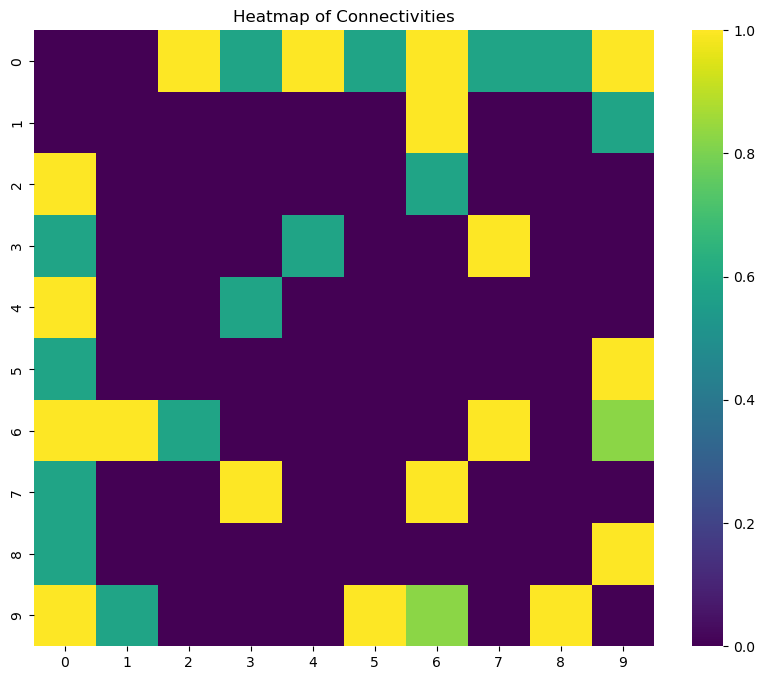

In [16]:
plt.figure(figsize=(10, 8))  # You can adjust the figure size
sns.heatmap(adata.obsp['connectivities'].toarray(), cmap="viridis")  # You can choose a different colormap

plt.title("Heatmap of Connectivities")
plt.show()

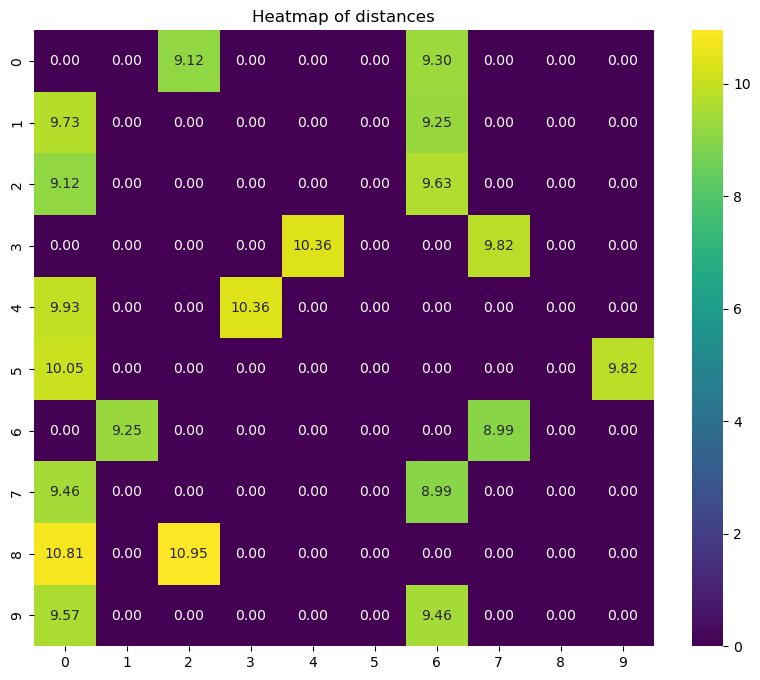

In [7]:
plt.figure(figsize=(10, 8))  # You can adjust the figure size
sns.heatmap(adata.obsp['distances'].toarray(), cmap="viridis",annot=True, fmt=".2f")  # You can choose a different colormap

plt.title("Heatmap of distances")
plt.show()

In [22]:
distances = adata.obsp['connectivities'].toarray()
import numpy as np
focal, neighbors = np.where(adata.obsp['connectivities'].toarray() > 0)
idx = adata.obs_names

graph_df = pd.DataFrame(
    {
        "focal": idx[focal],
        "neighbor": idx[neighbors],
        "weight": distances[focal, neighbors],
    }
)

In [23]:
graph_df

,focal,neighbor,weight
0,0,2,1.000000
1,0,3,0.584953
2,0,4,1.000000
3,0,5,0.584962
4,0,6,1.000000
5,0,7,0.584958
6,0,8,0.584957
7,0,9,1.000000
8,1,6,1.000000
9,1,9,0.584967


In [6]:
distances = adata.obsp['distances'].toarray()
import numpy as np
focal, neighbors = np.where(adata.obsp['distances'].toarray() > 0)
idx = adata.obs_names

graph_df = pd.DataFrame(
    {
        "focal": idx[focal],
        "neighbor": idx[neighbors],
        "weight": distances[focal, neighbors],
    }
)
graph_df

,focal,neighbor,weight
0,0,2,9.117372
1,0,6,9.302170
2,1,0,9.728170
3,1,6,9.251448
4,2,0,9.117372
5,2,6,9.628993
6,3,4,10.359506
7,3,7,9.821766
8,4,0,9.930584
9,4,3,10.359506


Dealing with sparse matrix

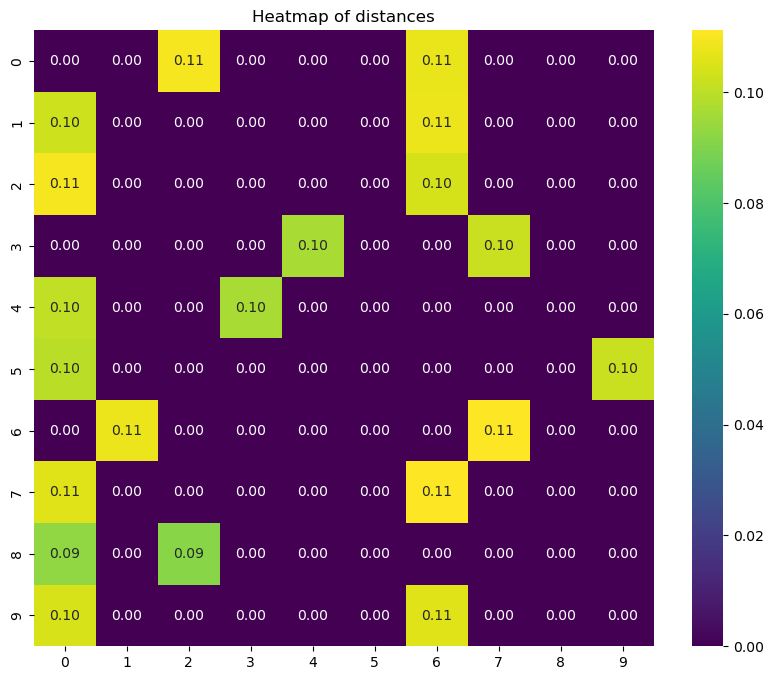

In [18]:
distances = adata.obsp['distances'].toarray()
distances[distances>0] = 1/(distances[distances>0])

plt.figure(figsize=(10, 8))  # You can adjust the figure size
sns.heatmap(distances, cmap="viridis",annot=True, fmt=".2f")  # You can choose a different colormap

plt.title("Heatmap of distances")
plt.show()

In [30]:
sparse_dist_matrix = adata.obsp['distances']
sparse_inv_matrix = sparse_dist_matrix.copy()
sparse_inv_matrix.data = 1 / sparse_inv_matrix.data
sparse_inv_matrix.data[sparse_inv_matrix.data == float('inf')] = 0

In [31]:
sparse_inv_matrix = sparse_inv_matrix.tocoo()
sparse_inv_matrix.row

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9],
      dtype=int32)

In [20]:
from scipy.sparse import csr_matrix
data = [1, 2, 3]
row_indices = [0, 1, 2]
column_indices = [1, 0, 2]
sparse_matrix = csr_matrix((data, (row_indices, column_indices)), shape=(3, 3))

In [24]:
sparse_matrix.toarray()

array([[0, 1, 0],
       [2, 0, 0],
       [0, 0, 3]])

In [28]:
sparse_matrix

<3x3 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [29]:
arr = ([[0,1,2],[2,0,0],[0,0,3]])
sparse_matrix = csr_matrix(arr)

<3x3 sparse matrix of type '<class 'numpy.int64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [34]:
x = [1,23,56,7]

In [26]:
import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os
%matplotlib inline

In [28]:
W = lps.weights.W.from_adjlist(graph_df)
W.set_transform("r")

In [ ]:
adata.uns.setdefault("spatial", {})
adata.uns["spatial"][graph_name] = W

In [4]:
import cupy as cp
import cupyx
import scanpy as sc
import scanpy as sc
import numpy as np
from cupyx.scipy.sparse import csr_matrix
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import random
import pandas as pd
import voyagerpy as vp
import geopandas as gpd
from collections import OrderedDict
from anndata import AnnData
path_016 = "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Human_Colon_Cancer_binned_outputs/binned_outputs/square_016um"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_2"
andata = sc.read_h5ad(os.path.join(pathout, "andata_save_colon.h5ad"))
from scipy.sparse import csr_matrix
andata = andata.copy()
andata.X = csr_matrix(andata.X)
andata = sc.pp.subsample(andata, n_obs=10_000,copy=True)
andata.layers['scale'] = andata.X
andata.layers['log'] = andata.layers['log']
scale = 1
visium_spots = gpd.GeoSeries.from_xy(andata.obsm['spatial'][:,0], andata.obsm['spatial'][:,1]).scale(scale, scale, origin=(0, 0))
_ = vp.spatial.set_geometry(andata, geom="spot_poly", values=visium_spots)
andata.X = andata.layers['log']
sc.pp.scale(andata, max_value=10)
sc.pp.pca(andata, n_comps=15)
andata

AnnData object with n_obs × n_vars = 10000 × 1500
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca', 'spatial', 'geometry'
    varm: 'PCs'
    layers: 'counts', 'log', 'scale'

In [ ]:
_eigen_values = None
_eigen_basis = None
n_dcs = None #  Number of diffusion components to use.
_rp_forest = None
n_neighbors = 25

In [7]:
def _get_indices_distances_from_dense_matrix(D, n_neighbors: int):
    sample_range = np.arange(D.shape[0])[:, None]
    indices = np.argpartition(D, n_neighbors - 1, axis=1)[:, :n_neighbors]
    indices = indices[sample_range, np.argsort(D[sample_range, indices])]
    distances = D[sample_range, indices]
    return indices, distances

In [9]:
from sklearn.metrics import pairwise_distances
_distances = pairwise_distances(andata.obsm['X_pca'], metric='euclidean')
knn_indices, knn_distances = _get_indices_distances_from_dense_matrix(_distances, n_neighbors = 25)

In [15]:
def _get_sparse_matrix_from_indices_distances_numpy(
    indices, distances, n_obs, n_neighbors
):
    n_nonzero = n_obs * n_neighbors
    indptr = np.arange(0, n_nonzero + 1, n_neighbors)
    D = csr_matrix(
        (
            distances.copy().ravel(),  # copy the data, otherwise strange behavior here
            indices.copy().ravel(),
            indptr,
        ),
        shape=(n_obs, n_obs),
    )
    D.eliminate_zeros()
    return D

In [16]:
_distances = _get_sparse_matrix_from_indices_distances_numpy(indices = knn_indices, distances = knn_distances, n_obs = andata.X.shape[0], n_neighbors =25)
_distances

<10000x10000 sparse matrix of type '<class 'numpy.float32'>'
	with 239444 stored elements in Compressed Sparse Row format>

In [18]:
Dsq = _distances.power(2)
Dsq

<10000x10000 sparse matrix of type '<class 'numpy.float32'>'
	with 239444 stored elements in Compressed Sparse Row format>

In [20]:
def _ind_dist_slow(D,n_neighbors):
    indices = np.zeros((D.shape[0], n_neighbors), dtype=int)
    distances = np.zeros((D.shape[0], n_neighbors), dtype=D.dtype)
    n_neighbors_m1 = n_neighbors - 1
    for i in range(indices.shape[0]):
        neighbors = D[i].nonzero()  # 'true' and 'spurious' zeros
        indices[i, 0] = i
        distances[i, 0] = 0
        # account for the fact that there might be more than n_neighbors
        # due to an approximate search
        # [the point itself was not detected as its own neighbor during the search]
        if len(neighbors[1]) > n_neighbors_m1:
            sorted_indices = np.argsort(D[i][neighbors].A1)[:n_neighbors_m1]
            indices[i, 1:] = neighbors[1][sorted_indices]
            distances[i, 1:] = D[i][
                neighbors[0][sorted_indices], neighbors[1][sorted_indices]
            ]
        else:
            indices[i, 1:] = neighbors[1]
            distances[i, 1:] = D[i][neighbors]
    return indices, distances

In [26]:
n_neighbors = 25
indices = np.zeros((Dsq.shape[0], n_neighbors), dtype=int)
distances = np.zeros((Dsq.shape[0], n_neighbors), dtype=Dsq.dtype)
n_neighbors_m1 = n_neighbors - 1

In [27]:
indices.shape[0]

10000

In [28]:
Dsq[0].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], dtype=int32),
 array([  20,   84,  275, 1292, 1837, 1849, 2073, 2750, 2948, 3004, 3218,
        3693, 3966, 4366, 4445, 4884, 5032, 5389, 5542, 5767, 5896, 7240,
        8445, 9482], dtype=int32))

In [32]:
n_neighbors_m1

24

In [33]:
D = Dsq
for i in range(indices.shape[0]):
    neighbors = D[i].nonzero()  # 'true' and 'spurious' zeros
    indices[i, 0] = i
    distances[i, 0] = 0
    # account for the fact that there might be more than n_neighbors
    # due to an approximate search
    # [the point itself was not detected as its own neighbor during the search]
    if len(neighbors[1]) > n_neighbors_m1:
        sorted_indices = np.argsort(D[i][neighbors].A1)[:n_neighbors_m1]
        indices[i, 1:] = neighbors[1][sorted_indices]
        distances[i, 1:] = D[i][
            neighbors[0][sorted_indices], neighbors[1][sorted_indices]
        ]
    else:
        indices[i, 1:] = neighbors[1]
        distances[i, 1:] = D[i][neighbors]

ValueError: could not broadcast input array from shape (23,) into shape (24,)

In [38]:
indices[i, 1:].shape

(24,)

In [21]:
indices, distances = _ind_dist_slow(Dsq, n_neighbors=25)

ValueError: could not broadcast input array from shape (23,) into shape (24,)